In [1]:
import numpy as np
import pandas as pd
from scipy import sparse

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import diffusion_dist as diff

import matplotlib.pyplot as plt

from sklearn import decomposition, preprocessing
from torch.utils.data import Dataset, DataLoader

import model.autoencoder as ae

from dataset import *

import utils
from model.loss import *
from diffusion_dist import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import phate
import umap 

In [2]:
rna_dataset = hema_rna(standardize=False, anchor = "MEP")
atac_dataset = hema_atac(standardize=False, anchor = "MEP")

In [3]:
rna_CONFIG = { 
    'in_features': rna_dataset.counts.shape[1],
    'layers': [256, 64, 32, 4], # number of nodes in each layer of encoder and decoder.
    'minibatch_size': 256,
    'use_batchnorm': True, # use batch normalization layer.
    'use_tanh': False, # tanh before latent visualization.
}

atac_CONFIG = { 
    'in_features': atac_dataset.counts.shape[1],
    'layers': [rna_dataset.counts.shape[1], 256, 64, 4], # number of nodes in each layer of encoder and decoder.
    'minibatch_size': 256,
    'use_batchnorm': True, # use batch normalization layer.
    'use_tanh': False, # tanh before latent visualization.
}

In [4]:
train_rna_loader = DataLoader(rna_dataset, batch_size = rna_CONFIG["minibatch_size"], shuffle = True)
train_atac_loader = DataLoader(atac_dataset, batch_size = atac_CONFIG["minibatch_size"], shuffle = True)
test_rna_loader = DataLoader(rna_dataset, batch_size = len(rna_dataset), shuffle = False)
test_atac_loader = DataLoader(atac_dataset, batch_size = len(atac_dataset), shuffle = False)

for data in test_rna_loader:
    U_t1, Diff1 = phate_similarity(data["raw"], 
                                  # control radius with decay
                                  n_neigh = 5, 
                                #   t = 8, 
                                  t = 20,
                                  use_potential = True, 
                                  # control radius with decay, if thresh equals to 0, the decaying of the kernel function is still calculated adaptively, with the equation np.exp(-1 * np.power(pdx, self.decay)) and pdx = (pdx.T / dist_kth).T
                                  thresh = 0,
                                  # decay gets larger, the radius get smaller, when decay gets infinity, the radius equals to the exact kth neighbor distance: radius = dist_kth * np.power(-1 * np.log(thresh),1/decay), the node outside the distance will be not connected
                                  # decay gets smaller, can be efficient
                                  decay = 40)

    
    Diff1 = torch.FloatTensor(Diff1).to(device)
    U_t1 = torch.FloatTensor(U_t1).to(device)
    # X_umap1 = umap.UMAP(n_components=2).fit_transform(data["raw"].numpy())
    # X_tsne1 = TSNE(n_components = 2).fit_transform(data["raw"].numpy())
    # X_phate1 = phate.PHATE(n_components=2).fit_transform(data["raw"].numpy())


    

for data in test_atac_loader:
    x_lsi = lsi_ATAC(data["raw"])
    U_t2, Diff2 = phate_similarity(x_lsi, 
                                  n_neigh = 5, 
                                  t = 4, # 20 
                                  use_potential = True,
                                  thresh = 0,
                                  decay = 10)


      
    
    Diff2 = torch.FloatTensor(Diff2).to(device)
    U_t2 = torch.FloatTensor(U_t2).to(device)
    # X_umap2 = umap.UMAP(n_components=2).fit_transform(data["raw"].numpy())
    # X_tsne2 = TSNE(n_components = 2).fit_transform(data["raw"].numpy())
    # X_phate2 = phate.PHATE(n_components=2).fit_transform(data["raw"].numpy())

In [5]:
# plot_latent(z1 = X_phate1, z2 = X_phate2, anno1 = symsim_r1b1.cell_labels, anno2 = symsim_r1b2.cell_labels, mode = "separate",save = None)

In [6]:
encoder1 = ae.Encoder(rna_CONFIG).to(device)
encoder2 = ae.Encoder(atac_CONFIG).to(device)
fusion = ae.Fusion(in_channels = rna_CONFIG['layers'][-1], hidden_channels = 4, embed_channels = 2, use_hidden = True)
decoder1 = ae.Decoder(rna_CONFIG)
decoder2 = ae.Decoder(atac_CONFIG)


optimizer_rna = torch.optim.Adam(list(encoder1.parameters()) + list(decoder1.parameters()), lr = 5e-4)
optimizer_atac = torch.optim.Adam(list(encoder2.parameters()) + list(decoder2.parameters()), lr = 5e-4)
optimizer_dist_rna = torch.optim.Adam(list(encoder1.parameters()) + list(fusion.parameters()), lr = 5e-4)
optimizer_dist_atac = torch.optim.Adam(list(encoder2.parameters()) + list(fusion.parameters()), lr = 5e-4)

In [7]:
disc = ae.discriminator(infeatures = rna_CONFIG['layers'][-1] + 2, hidden1 = 64, hidden2 = 32, hidden3 = 1).to(device)
optimizer_D = torch.optim.Adam(disc.parameters(), lr = 1e-3)

In [8]:
# cannot reconstruct original atac-seq data, too hard
utils.pretrain_embedding(encoder1 = encoder1, encoder2 = encoder2, fusion = fusion, decoder1 = decoder1, decoder2 = decoder2, data_loader1 = train_rna_loader, data_loader2 = train_atac_loader, diff_sim1 = Diff1, diff_sim2 = Diff2, recon_opt1 = optimizer_rna, recon_opt2 = optimizer_atac, dist_opt1 = optimizer_dist_rna, dist_opt2 = optimizer_dist_atac, n_epochs = 51, lamb_r1 = 1, lamb_r2 = 1, dist_mode = "mse")

epoch:  0 RNA recon loss: 1.06620, RNA dist loss: 0.60375 ATAC recon loss: 0.13038, ATAC dist loss: 0.63169
epoch:  10 RNA recon loss: 0.13571, RNA dist loss: 0.11767 ATAC recon loss: 0.07638, ATAC dist loss: 0.21905
epoch:  20 RNA recon loss: 0.10417, RNA dist loss: 0.08195 ATAC recon loss: 0.08814, ATAC dist loss: 0.21749
epoch:  30 RNA recon loss: 0.08334, RNA dist loss: 0.08738 ATAC recon loss: 0.05698, ATAC dist loss: 0.08578
epoch:  40 RNA recon loss: 0.07575, RNA dist loss: 0.07402 ATAC recon loss: 0.07133, ATAC dist loss: 0.07030
epoch:  50 RNA recon loss: 0.06607, RNA dist loss: 0.06643 ATAC recon loss: 0.05811, ATAC dist loss: 0.08105


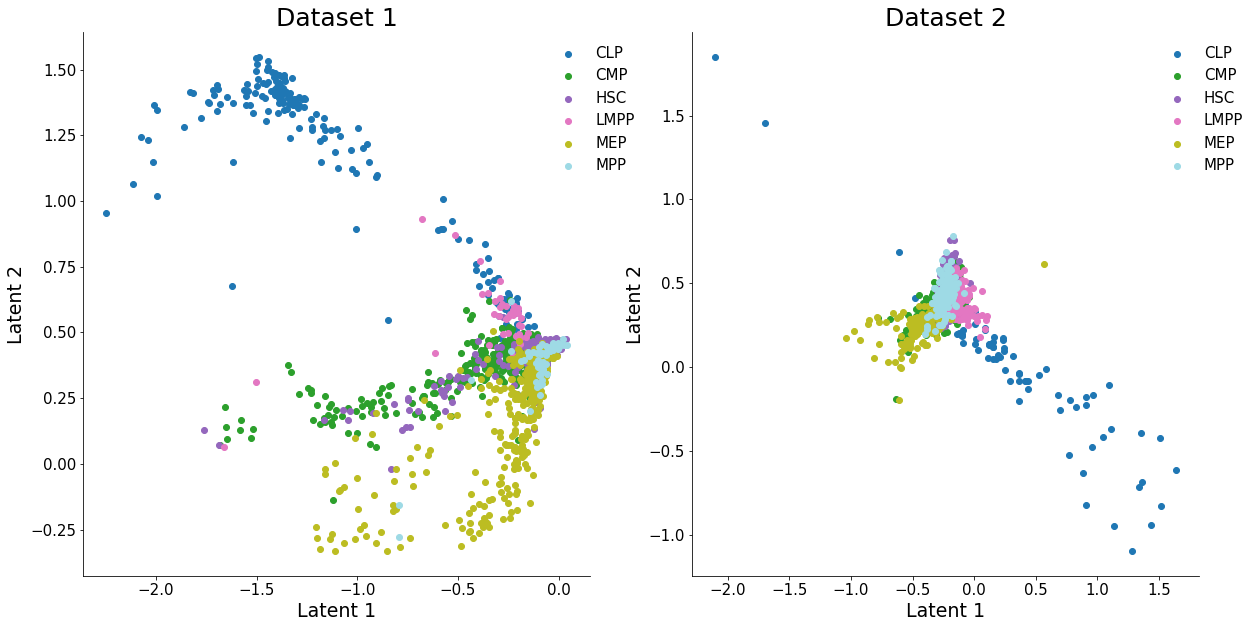

In [9]:
with torch.no_grad():
    for data in test_rna_loader:
        ae_coordinates1 = fusion(encoder1(data['count'].to(device))).cpu().detach().numpy()

    for data in test_atac_loader:
        ae_coordinates2 = fusion(encoder2(data['count'].to(device))).cpu().detach().numpy()

    plot_latent(z1 = ae_coordinates1, z2 = ae_coordinates2, anno1 = rna_dataset.cell_labels, anno2 = atac_dataset.cell_labels, mode = "separate",save = None)

In [15]:
utils.pre_train_disc(encoder1 = encoder1, encoder2 = encoder2, disc = disc, fusion = fusion, data_loader1 = train_rna_loader, data_loader2 = train_atac_loader, disc_opt = optimizer_D, n_epochs = 51, use_anchor = False)

epoch:  0 Discriminator loss: 0.13581
epoch:  10 Discriminator loss: 0.11841
epoch:  20 Discriminator loss: 0.20412
epoch:  30 Discriminator loss: 0.13693
epoch:  40 Discriminator loss: 0.10991
epoch:  50 Discriminator loss: 0.09893


In [14]:
utils.train_unpaired(encoder1 = encoder1, encoder2 = encoder2, decoder1 = decoder1, decoder2 = decoder2, fusion = fusion, disc = disc, data_loader1 = train_rna_loader, data_loader2 = train_atac_loader, diff_sim1 = Diff1, diff_sim2 = Diff2, recon_opt1 = optimizer_rna, recon_opt2 = optimizer_atac, dist_opt1 = optimizer_dist_rna, dist_opt2 = optimizer_dist_atac, disc_opt = optimizer_D, n_epochs=151, n_iter=31, n_iter2 = 1, lamb_r1 = 0, lamb_r2 = 0, lamb_disc=1, dist_mode = "mse", use_anchor = False)

epoch:  0 RNA recon loss: 0.06635, RNA dist loss: 0.09902 ATAC recon loss: 0.06917, ATAC dist loss: 0.35978 Discriminator loss: 0.31970
epoch:  10 RNA recon loss: 0.06368, RNA dist loss: 0.11816 ATAC recon loss: 0.06694, ATAC dist loss: 0.16652 Discriminator loss: 0.44471
epoch:  20 RNA recon loss: 0.05928, RNA dist loss: 0.09319 ATAC recon loss: 0.06048, ATAC dist loss: 0.16045 Discriminator loss: 0.43895
epoch:  30 RNA recon loss: 0.05793, RNA dist loss: 0.14893 ATAC recon loss: 0.06986, ATAC dist loss: 0.19690 Discriminator loss: 0.52449
epoch:  40 RNA recon loss: 0.05825, RNA dist loss: 0.10848 ATAC recon loss: 0.06193, ATAC dist loss: 0.18907 Discriminator loss: 0.51242
epoch:  50 RNA recon loss: 0.05374, RNA dist loss: 0.10804 ATAC recon loss: 0.06673, ATAC dist loss: 0.31492 Discriminator loss: 0.54939
epoch:  60 RNA recon loss: 0.05395, RNA dist loss: 0.11590 ATAC recon loss: 0.05128, ATAC dist loss: 0.12324 Discriminator loss: 0.51739
epoch:  70 RNA recon loss: 0.05334, RNA di

In [14]:
# torch.save({
#     'encoder1': encoder1.state_dict(),
#     'encoder2': encoder2.state_dict(),
#     'disc': disc.state_dict(),
#     'fusion': fusion.state_dict(),
#     'decoder1': decoder1.state_dict(),
#     'decoder2': decoder2.state_dict(),
#     'config1': rna_CONFIG,
#     'config2': atac_CONFIG,
#     'Diff1': Diff1,
#     'Diff2': Diff2
# }, './saved_model/endo_phate_new_withIAC3_pretrain_2latent.pt')

In [21]:
state = torch.load('./saved_model/hm/hm_model1.pt')

encoder1 = ae.Encoder(rna_CONFIG).to(device)
encoder1.load_state_dict(state['encoder1'])

encoder2 = ae.Encoder(atac_CONFIG).to(device)
encoder2.load_state_dict(state['encoder2'])

fusion = ae.Fusion(in_channels = rna_CONFIG['layers'][-1], hidden_channels = 4, embed_channels = 2, use_hidden = True)
fusion.load_state_dict(state['fusion'])

decoder1 = ae.Decoder(rna_CONFIG).to(device)
decoder1.load_state_dict(state['decoder1'])

decoder2 = ae.Decoder(atac_CONFIG).to(device)
decoder2.load_state_dict(state['decoder2'])

disc = ae.discriminator(infeatures = rna_CONFIG['layers'][-1]+2, hidden1 = 64, hidden2 = 32, hidden3 = 1).to(device)
disc.load_state_dict(state['disc'])

<All keys matched successfully>

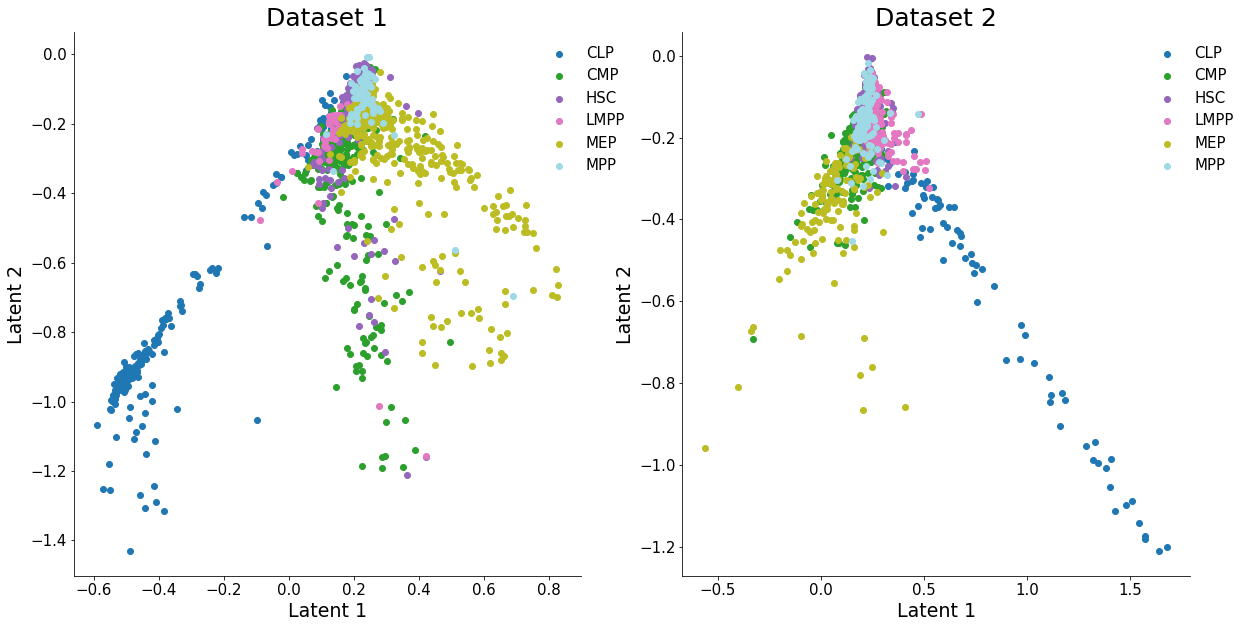

In [15]:
with torch.no_grad():
    for data in test_rna_loader:
        ae_coordinates1 = fusion(encoder1(data['count'].to(device))).cpu().detach().numpy()

    for data in test_atac_loader:
        ae_coordinates2 = fusion(encoder2(data['count'].to(device))).cpu().detach().numpy()

    plot_latent(z1 = ae_coordinates1, z2 = ae_coordinates2, anno1 = rna_dataset.cell_labels, anno2 = atac_dataset.cell_labels, mode = "separate",save = None)

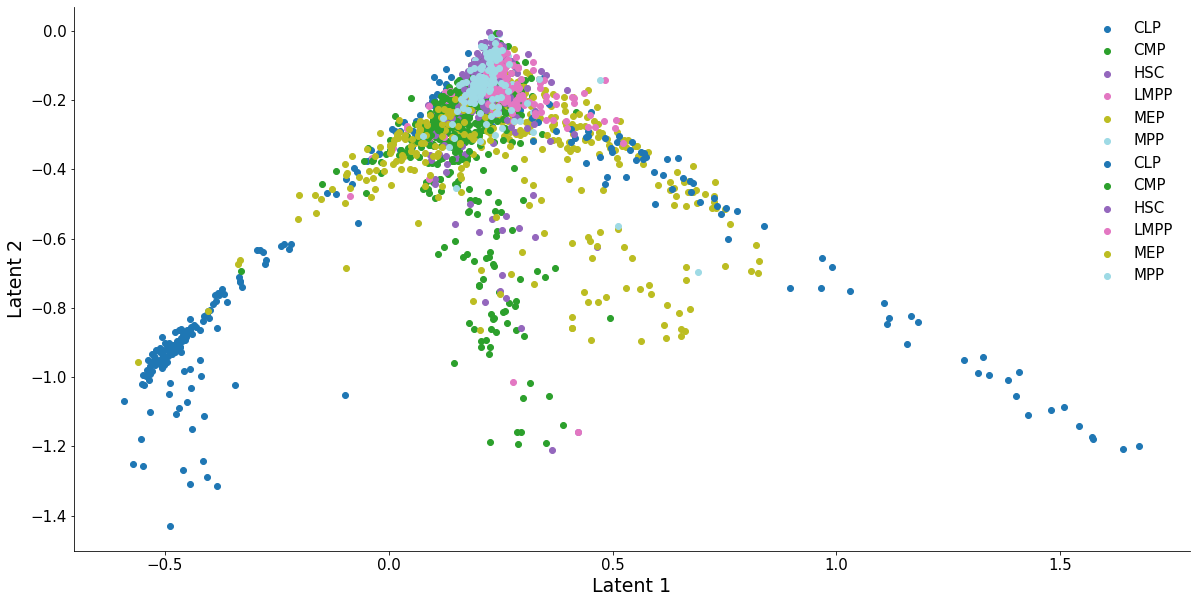

In [16]:
plot_latent(z1 = ae_coordinates1, z2 = ae_coordinates2, anno1 = rna_dataset.cell_labels, anno2 = atac_dataset.cell_labels, mode = "joint",save = None)#"result/hm/joint.png")

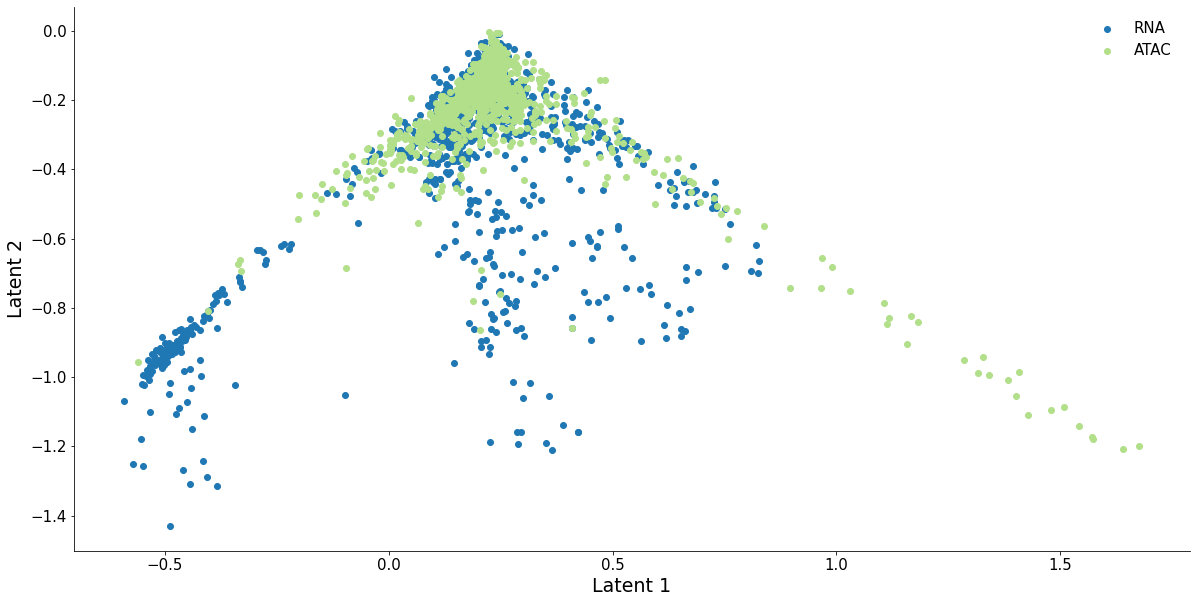

In [17]:
plot_latent(z1 = ae_coordinates1, z2 = ae_coordinates2, anno1 = rna_dataset.cell_labels, anno2 = atac_dataset.cell_labels, mode = "modality",save = None)#"result/hm/modalities.png")

In [18]:
# torch.save({
#     'encoder1': encoder1.state_dict(),
#     'encoder2': encoder2.state_dict(),
#     'disc': disc.state_dict(),
#     'fusion': fusion.state_dict(),
#     'decoder1': decoder1.state_dict(),
#     'decoder2': decoder2.state_dict(),
#     'config1': rna_CONFIG,
#     'config2': atac_CONFIG,
#     'Diff1': Diff1,
#     'Diff2': Diff2
# }, './saved_model/hm/hm_model2.pt')